# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2022-12-22 06:47:24--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2022-12-22 06:47:24 (33.7 MB/s) - ‘cifar.py’ saved [2396/2396]



In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


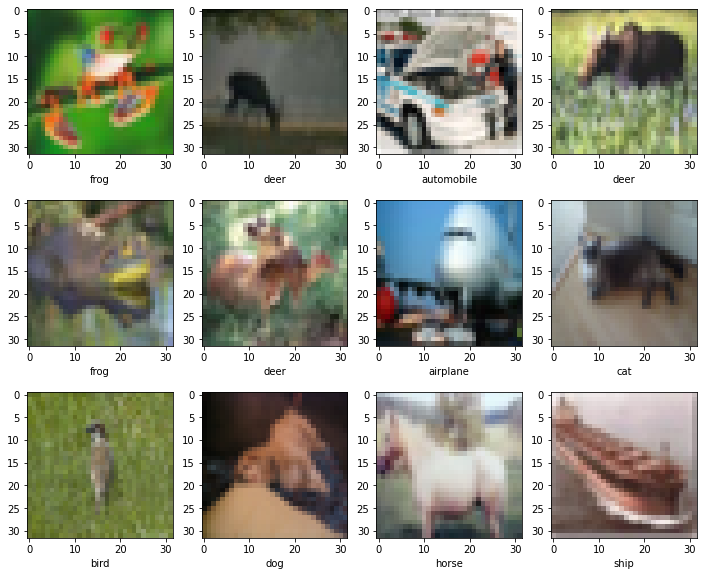

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
import torch, torch.nn as nn
import torchvision
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3005, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 2.024s
  training loss (in-iteration): 	2.035847
  validation accuracy: 			34.30 %
Epoch 2 of 100 took 1.810s
  training loss (in-iteration): 	1.858280
  validation accuracy: 			36.56 %
Epoch 3 of 100 took 1.842s
  training loss (in-iteration): 	1.791217
  validation accuracy: 			38.72 %
Epoch 4 of 100 took 1.909s
  training loss (in-iteration): 	1.741492
  validation accuracy: 			40.21 %
Epoch 5 of 100 took 1.835s
  training loss (in-iteration): 	1.702164
  validation accuracy: 			41.54 %
Epoch 6 of 100 took 1.841s
  training loss (in-iteration): 	1.669019
  validation accuracy: 			40.82 %
Epoch 7 of 100 took 1.797s
  training loss (in-iteration): 	1.638968
  validation accuracy: 			42.13 %
Epoch 8 of 100 took 1.791s
  training loss (in-iteration): 	1.612798
  validation accuracy: 			42.97 %
Epoch 9 of 100 took 1.843s
  training loss (in-iteration): 	1.590129
  validation accuracy: 			44.34 %
Epoch 10 of 100 took 1.758s
  training loss (in-iteration): 	1.571202
  v

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'23. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		49.52 %
We need more magic! Follow instructons below


# Baseline

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, 
                                    kernel_size=3))

In [ ]:
model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2

In [ ]:
model.add_module('flatten', Flatten())

In [ ]:
model.add_module('linear', nn.Linear(3 * 750, 100))

In [ ]:
model.add_module('ReLU', nn.ReLU())

In [ ]:
model.add_module('Dropout', nn.Dropout(0.1))

In [ ]:
model.add_module('linear_1', nn.Linear(100,64))

In [ ]:
compute_loss(X_train[:4], y_train[:4])

tensor(4.0639, grad_fn=<MeanBackward0>)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 13.068s
  training loss (in-iteration): 	1.877494
  validation accuracy: 			43.57 %
Epoch 2 of 20 took 13.435s
  training loss (in-iteration): 	1.524567
  validation accuracy: 			50.91 %
Epoch 3 of 20 took 13.580s
  training loss (in-iteration): 	1.345052
  validation accuracy: 			53.24 %
Epoch 4 of 20 took 12.506s
  training loss (in-iteration): 	1.225512
  validation accuracy: 			57.47 %
Epoch 5 of 20 took 12.528s
  training loss (in-iteration): 	1.136317
  validation accuracy: 			59.05 %
Epoch 6 of 20 took 12.609s
  training loss (in-iteration): 	1.058827
  validation accuracy: 			59.96 %
Epoch 7 of 20 took 12.651s
  training loss (in-iteration): 	0.987839
  validation accuracy: 			60.36 %
Epoch 8 of 20 took 13.312s
  training loss (in-iteration): 	0.936142
  validation accuracy: 			61.66 %
Epoch 9 of 20 took 13.428s
  training loss (in-iteration): 	0.874096
  validation accuracy: 			61.82 %
Epoch 10 of 20 took 13.393s
  training loss (in-iteration): 	0.826585
  v

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'23. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		60.20 %
Achievement unlocked: 70lvl Warlock!


# Batchnorm

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, 
                                    kernel_size=3))
model.add_module('batch', nn.BatchNorm2d(10))
model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2
model.add_module('flatten', Flatten())
model.add_module('linear', nn.Linear(3 * 750, 100))
model.add_module('batch_1', nn.BatchNorm1d(100))
model.add_module('ReLU', nn.ReLU())
model.add_module('Dropout', nn.Dropout(0.1))
model.add_module('linear_1', nn.Linear(100,32))


In [ ]:
compute_loss(X_train[:4], y_train[:4])

tensor(3.7947, grad_fn=<MeanBackward0>)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 10 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-32 // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-32 // batch_size :]) * 100))

Epoch 1 of 10 took 20.476s
  training loss (in-iteration): 	1.431246
  validation accuracy: 			38.00 %
Epoch 2 of 10 took 19.069s
  training loss (in-iteration): 	0.924369
  validation accuracy: 			58.00 %
Epoch 3 of 10 took 20.520s
  training loss (in-iteration): 	1.061220
  validation accuracy: 			54.00 %
Epoch 4 of 10 took 19.612s
  training loss (in-iteration): 	1.357319
  validation accuracy: 			64.00 %
Epoch 5 of 10 took 20.181s
  training loss (in-iteration): 	1.002025
  validation accuracy: 			50.00 %
Epoch 6 of 10 took 18.470s
  training loss (in-iteration): 	0.939577
  validation accuracy: 			44.00 %
Epoch 7 of 10 took 19.030s
  training loss (in-iteration): 	0.917755
  validation accuracy: 			54.00 %
Epoch 8 of 10 took 18.859s
  training loss (in-iteration): 	0.588702
  validation accuracy: 			54.00 %
Epoch 9 of 10 took 19.000s
  training loss (in-iteration): 	0.674899
  validation accuracy: 			64.00 %
Epoch 10 of 10 took 19.533s
  training loss (in-iteration): 	0.561153
  v

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'23. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		62.92 %
Achievement unlocked: 70lvl Warlock!


# Аугментация

In [ ]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: ignored

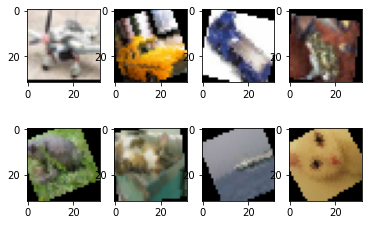

In [ ]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

# Задание 4 __Основное__: The Quest For A Better Network

In [ ]:
from cifar import load_cifar10
import numpy as np
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


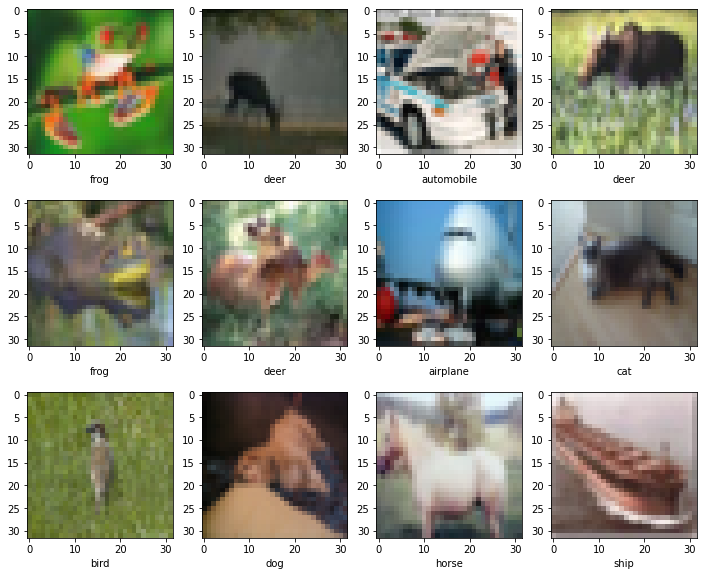

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = nn.Sequential()
#First block
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, 
                                    kernel_size=3, padding=1))
model.add_module('ReLU1', nn.ReLU())
model.add_module('batch1', nn.BatchNorm2d(16))
model.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, 
                                    kernel_size=3, padding=1))
model.add_module('ReLU2', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2)) # max pooling 2x2
#Second
model.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, 
                                    kernel_size=3, padding=1))
model.add_module('ReLU3', nn.ReLU())
model.add_module('batch2', nn.BatchNorm2d(64))
model.add_module('conv4', nn.Conv2d(in_channels=64, out_channels=64, 
                                    kernel_size=3, padding=1))
model.add_module('ReLU4', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2)) # max pooling 2x2

model.add_module('Dropout1', nn.Dropout2d(0.2))
model.add_module('flatten', Flatten())
model.add_module('Dropout2', nn.Dropout(0.2))
model.add_module('linear1', nn.Linear(4096, 512))
model.add_module('batch3', nn.BatchNorm1d(512))
model.add_module('ReLU5', nn.ReLU())
model.add_module('linear2', nn.Linear(512, 128))
model.add_module('ReLU6', nn.ReLU())
model.add_module('Dropout3', nn.Dropout(0.2))
model.add_module('linear3', nn.Linear(128,10))
model.add_module('soft', nn.LogSoftmax(dim=1))


In [ ]:
model = model.to(device)

In [ ]:
compute_loss(X_train[:4], y_train[:4])

tensor(2.3457, grad_fn=<MeanBackward0>)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 185.310s
  training loss (in-iteration): 	1.286813
  validation accuracy: 			67.21 %
Epoch 2 of 20 took 182.471s
  training loss (in-iteration): 	0.921249
  validation accuracy: 			72.53 %
Epoch 3 of 20 took 175.738s
  training loss (in-iteration): 	0.789751
  validation accuracy: 			75.46 %
Epoch 4 of 20 took 185.332s
  training loss (in-iteration): 	0.693686
  validation accuracy: 			76.46 %
Epoch 5 of 20 took 185.205s
  training loss (in-iteration): 	0.617883
  validation accuracy: 			78.16 %
Epoch 6 of 20 took 183.768s
  training loss (in-iteration): 	0.548264
  validation accuracy: 			77.41 %
Epoch 7 of 20 took 184.897s
  training loss (in-iteration): 	0.486751
  validation accuracy: 			78.40 %
Epoch 8 of 20 took 188.242s
  training loss (in-iteration): 	0.434774
  validation accuracy: 			78.91 %
Epoch 9 of 20 took 184.289s
  training loss (in-iteration): 	0.385201
  validation accuracy: 			79.68 %
Epoch 10 of 20 took 186.187s
  training loss (in-iteration): 	0.

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'23. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		80.29 %
Achievement unlocked: 110lvl Warlock!


(please read it at least diagonally)

* Основная задача -- сделать нейросеть, которая имеет достаточный accuracy, чтобы ей можно было пользоваться.
* В конце есть __mini-report__, который вам надо будет заполнить. Я рекомендую прочитать этот текст и репорт в начале и заполнять его по ходу ваших исследований.
 
## Оценивание
* Начинаем с 0
* +20% за заполнения ваших шагов в репорта.
* +20% за сеть, которая выбивает более 20% accuracy
* +10% за пробитие каждого из порогов ниже на __TEST__ датасете:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)

Способы заработать доп очки:

* Очевидно, получить выше скор )
* Реализовать реальную архитектуру, например, ResNet, DenseNet, и тд
* Сделать что-нибудь необычное с вашей сеткой. Например, "Супер маленькая/быстрая нейронка, которая получит 80%".
* Подробный анализ полученных результатов. (saliency maps и тд)

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`



In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    transform = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.ToTensor(),
              normalize,
    ])


    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 2, padding = 3),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride = 2)
        self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(256, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
num_classes = 10
num_epochs = 20
batch_size = 50
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)

In [ ]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Loss: 1.3918
Accuracy of the network on the 5000 validation images: 53.14 %
Epoch [2/20], Loss: 1.0267
Accuracy of the network on the 5000 validation images: 66.0 %
Epoch [3/20], Loss: 1.6617
Accuracy of the network on the 5000 validation images: 71.38 %
Epoch [4/20], Loss: 1.4659
Accuracy of the network on the 5000 validation images: 73.78 %
Epoch [5/20], Loss: 1.7202
Accuracy of the network on the 5000 validation images: 75.9 %
Epoch [6/20], Loss: 0.4336
Accuracy of the network on the 5000 validation images: 76.42 %
Epoch [7/20], Loss: 1.2544
Accuracy of the network on the 5000 validation images: 76.22 %
Epoch [8/20], Loss: 1.6161
Accuracy of the network on the 5000 validation images: 78.94 %
Epoch [9/20], Loss: 0.4143
Accuracy of the network on the 5000 validation images: 78.94 %
Epoch [10/20], Loss: 0.2166
Accuracy of the network on the 5000 validation images: 79.9 %
Epoch [11/20], Loss: 1.0847
Accuracy of the network on the 5000 validation images: 79.54 %
Epoch [12/2

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 80.4 %


In [ ]:
test_accuracy = correct / total

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons above")


Final results:
  test accuracy:		80.40 %
Achievement unlocked: 110lvl Warlock!


In [ ]:
# you might as well write your solution here :)

## Отчет
Все креативные подходы только приветствуются, но вот примерный минимум что хочется видеть

* Идея
* Краткая история попыток и улучшений
* Что попало в финальную версию и почему?
* Как сетка и учится и почему?
* Все регуляризации, приемы и прочие штуки, которые вы пробовали и что получилось, что нет
* Нет нужды расписывать мат модели, если только конечно не очень хочется.

### Примеры
- `"Я попробовал это, а еще это и это, второй оказался лучше. И еще мне не нравится название этого метода, так что я его не использую"` - OK, but can be better
- `"Я проанализировал эти и вот эти статьи|ссылки|посты, попробовал адаптировать их к этой задаче и вот что вышло, результат 1 с анализом, результат 2 с анализом и тд"` - the ideal one
- `"Я скопировал это с инета, особо не разбирался но вроде работает, но я никогда в этом не признаюсь, и буду находить любые оправдания, не смотря на то, что в работе это сразу видно"` - not_ok


## Привет, меня зовут Евгений Колосов, и это моя история
Давным-давно в далекой Галактике, когда до дедлайна было больше, чем 2 часа, мне пришла идея:

__Я хочу создать нейросетку, которая__
- будет решать задачу классификации изображений
- основная идея -  сделать нейросеть, которая имеет достаточный accuracy, чтобы ей можно было пользоваться.
- так получилось, потому что поставили такую задачу, которая даёт опыт в DL


Как я мог/могла быть таким/такой наивной?! Все норм

__Однажды, ничего не предвещало беды__
Эта штуковина наконец-то сошлась и

- Дала результат более 80% на тестовой выборке
- Сработал Adam в собственной сетке, не сработал SGD и высокий lr, а также уменьшение входных слоёв в свёрточных слоях. Сработало увеличение, добавление нормализаций, дропаута, слоёв активации
- Следующие шаги - сдать работу :D
- Надеюсь, 5 за работу

__Наконец, после 20 итераций и 0 чашек [чая/кофе]__
- Сверточная архитектура и resnet
- Описал выше

__В итоге, потратив 2 дня [минут, часов или дней] своей жизни на обучение сеток, я получил/ла__

- accuracy on training: __
- accuracy on validation: 80%
- accuracy on test: 80%

[опциональное место для послесловий и вселенских проклятий в адресс составителя домашки]